## Topic discovery: yelp review

In [1]:
# from huggingface_hub import hf_hub_download 
import torch
from datasets import load_dataset, load_from_disk
import evaluate
import transformers
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM
from transformers import TrainingArguments, Trainer
from peft import LoraConfig, TaskType, get_peft_model
from peft import PeftConfig, PeftModel
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from huggingface_hub import notebook_login
from accelerate import init_empty_weights, load_checkpoint_and_dispatch, infer_auto_device_map, dispatch_model

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, NMF, non_negative_factorization
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import re
import os
import glob
import itertools

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string

D:\cygdrive\d\projects\LLM_py38\venv\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
D:\cygdrive\d\projects\LLM_py38\venv\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
D:\cygdrive\d\projects\LLM_py38\venv\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
print(transformers.__version__)

4.35.2


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.3.0+cu118
True


In [4]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [5]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

def load_tokenizer_llm(AutoModelForClass, model_name, model_path, cache_dir, to_device=True, **kwargs):
    """
    if use load_in_4bit=True, do not set to_device=True
    kwargs:
        - device_map
        - torch_dtype
        - load_in_4bit
    """
    if not os.path.isfile(model_path + '/tokenizer.json'):
        print('no existing tokenizer found. Download from HF')
        tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                                  cache_dir=cache_dir,
                                                  **kwargs
                                                 ) # to load tokenizer to cache
    else:
        print('existing tokenizer found. Load from local')
        tokenizer = AutoTokenizer.from_pretrained(model_path, 
                                                  cache_dir=cache_dir, 
                                                  local_flies_only=True)
    if not bool(glob.glob(model_path + '/model*.safetensors')):
        print('no existing model found. Download from HF')
        model = AutoModelForClass.from_pretrained(model_name,
                                                     cache_dir=cache_dir,
                                                     **kwargs
                                                    )
    else:
        print('existing model found. Load from local')
        model = AutoModelForClass.from_pretrained(model_path, 
                                                 cache_dir=cache_dir,
                                                 local_files_only=True)
    
    if to_device:
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        #device.reset()
        model.to(device) # use GPU. Do not need this if using load_in_4bit as it's already been set to the correct devices
        
    return tokenizer, model

In [6]:
llm_repo_dir = 'D:/projects/LLM'
cache_dir = '/cygdrive/d/projects/LLM/.cache'
os.environ['TRANSFORMERS_CACHE'] = cache_dir
os.environ['HF_HOME'] = cache_dir + '/huggingface'
os.environ['XDG_CACHE_HOME'] = cache_dir
os.environ['HF_DATASETS_CACHE'] = cache_dir

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
model_name = 'google-bert/bert-base-cased'
model_path = cache_dir + '/models--google-bert--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e'

AutoModelForClass = AutoModelForSequenceClassification
to_device = True
tokenizer, model = load_tokenizer_llm(AutoModelForClass, model_name, model_path, cache_dir, to_device=to_device)

existing tokenizer found. Load from local
existing model found. Load from local


D:\cygdrive\d\projects\LLM_py38\venv\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /cygdrive/d/projects/LLM/.cache/models--google-bert--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
dataset_path = cache_dir + '/parquet/yelp_polarity' # cache_dir + '/parquet/yelp_review_full-e22176106d6e7534'
dataset_name = 'yelp_polarity' # yelp_review_full

if not os.path.isdir(dataset_path):
    dataset = load_dataset(dataset_name, cache_dir=cache_dir + '/parquet')
else:
    dataset = load_dataset(dataset_path)

In [9]:
tokenized_data_path = cache_dir + '/tokenized_dataset_yelp_polarity_bert'

tokenized_datasets = load_from_disk(tokenized_data_path)
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

In [10]:
print(type(small_train_dataset))
print(small_train_dataset.shape)

<class 'datasets.arrow_dataset.Dataset'>
(1000, 5)


### use fine-tuned BERT for word embedding

In [11]:
input_ids = torch.tensor(small_train_dataset['input_ids'], device=device)

In [12]:
ft_model_dir = cache_dir + '/ft_lora_yelp_polarity'
model_path = cache_dir + '/models--google-bert--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e'
num_labels = 2
model_pretrained = AutoModelForSequenceClassification.from_pretrained(model_path, 
                                                           num_labels=num_labels, 
                                                           cache_dir=cache_dir, 
                                                           local_files_only=True)
model_lora = PeftModel.from_pretrained(model_pretrained, ft_model_dir)
model_lora.to(device)
model_lora.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /cygdrive/d/projects/LLM/.cache/models--google-bert--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(28996, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(
                    in_features=768, out_features=768, bias=True
                    (lora_dropout): Dropout(p=0.1, inplace=False)
                    (lora_A): Linear(in_features=768, out_features=50, bias=False)
                    (lora_B): Linear(in_features=50, out_features=768, bias=False)
    

In [13]:
%%time

#cls_embedding = torch.tensor([]).to('cuda')
cls_embedding_lora = []

with torch.no_grad():
    for i in range(input_ids.shape[0]):
        output = model_lora(input_ids[i].reshape(1,-1),
                      output_hidden_states=True)
        cls_embedding_lora.append(output.hidden_states[-1][0,0,:].cpu().numpy())
cls_embedding_lora = np.array(cls_embedding_lora)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


CPU times: total: 21.8 s
Wall time: 42.4 s


D:\cygdrive\d\projects\LLM_py38\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


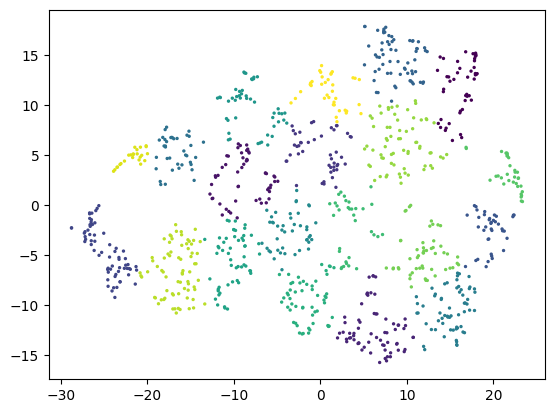

In [14]:
pipe = Pipeline([('scaler',StandardScaler()),
                 ('pca',PCA(n_components=20)),
                 ('tsne',TSNE(perplexity=20, learning_rate=1, random_state=123))
                ])
cls_embedding_lora_tsne = pipe.fit_transform(cls_embedding_lora)
km_lora = KMeans(n_clusters=20)
km_lora.fit(cls_embedding_lora_tsne)

plt.scatter(cls_embedding_lora_tsne[:,0],
            cls_embedding_lora_tsne[:,1], 
            s=2,
            c=km_lora.labels_)

In [15]:
nonzero_token_length = (np.array(small_train_dataset['input_ids'])!=0).sum(axis=1)

df_comment_from_label = pd.DataFrame({'comment':small_train_dataset['text'],
                                      'x':cls_embedding_lora_tsne[:,0],
                                      'y':cls_embedding_lora_tsne[:,1],
                                      'label':km_lora.labels_,
                                      'nonzero_token_length':nonzero_token_length,
                                      'sentiment':small_train_dataset['label']})

In [93]:
df_cluster_comment_length.columns

MultiIndex([('nonzero_token_length', 'mean'),
            ('nonzero_token_length',  'std')],
           )

In [100]:
df_cluster_comment_length = df_comment_from_label.groupby('label').agg({'nonzero_token_length':['mean','std']})
df_cluster_comment_length.columns = ['length_mean','length_std']
df_cluster_comment_sentiment = df_comment_from_label.groupby('label')['sentiment']\
                                .describe()[['count','mean','std']].sort_values('mean')

In [101]:
df_cluster_comment_sentiment.join(df_cluster_comment_length)

,count,mean,std,length_mean,length_std
label,,,,,
2,66.0,0.030303,0.172733,163.136364,17.010301
8,62.0,0.048387,0.216335,249.548387,40.803278
5,39.0,0.051282,0.223456,392.615385,49.107624
12,55.0,0.054545,0.229184,120.163636,14.287736
14,33.0,0.060606,0.242306,504.030303,19.714343
15,52.0,0.134615,0.344642,265.384615,64.325201
11,54.0,0.185185,0.392095,74.907407,10.222558
9,44.0,0.409091,0.497350,108.272727,12.826868
13,33.0,0.424242,0.501890,142.696970,22.557544


In [18]:
df_comment_from_label

,comment,x,y,label,nonzero_token_length,sentiment
0,"Decent size, decent selection, decent staff.\n...",1.079602,0.126466,13,130,1
1,I have definitely experienced better! Let's se...,22.253769,-1.165080,5,465,0
2,Food is mediocre at best. I came in one day an...,-22.178694,-6.975071,4,38,0
3,Best casino in the PHX area.,-26.446384,-1.943219,4,11,1
4,This place is a must try! Truly a fan of Skinn...,7.768639,16.319305,6,206,1
...,...,...,...,...,...,...
995,Great welcoming staff & friendly service. The...,-18.098648,-9.443006,17,39,0
996,"Trop d'attente, trop de pubs (\u00e7a fait vom...",-14.382864,-5.867665,17,63,0
997,"Beautiful men are a dime a dozen in Montreal, ...",-1.285205,-0.079022,9,118,1
998,The counter agent aggressively pushed the most...,15.750511,-13.660258,8,232,0


## LDA

In [19]:
# lowercase
# remove punctuations
# tokenization
# remove stopwords
# lemmatization
# tfidf
# LDA

## LDA on cluster of words from BERT

In [20]:
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jacky\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

def preprocess_pipeline(x):
    x = x.lower()
    x = remove_punctuation(x)
    x = re.sub("\d+", "", x)
    x = word_tokenize(x)
    x = [s for s in x if s not in stopwords.words('english')]
    x = list(set(x))
    return x
    
class Lemmatizer:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        
    def fit(self, X, y):
        return self
    
    def nltk_pos_tagger(self, nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:
            return None
        
    def lemmatize_sentence(self, sentence):
        nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
        wordnet_tagged = map(lambda x: (x[0], self.nltk_pos_tagger(x[1])), nltk_tagged)
        lemmatized_sentence = []
        
        for word, tag in wordnet_tagged:
            if tag is None:
                lemmatized_sentence.append(word)
            else:
                lemmatized_sentence.append(self.lemmatizer.lemmatize(word, tag))
                
        return str(lemmatized_sentence)
    
    def transform(self, x):
        return list(map(lambda x: self.lemmatize_sentence(x), x))

In [46]:
sample = list(map(preprocess_pipeline, small_train_dataset['text']))

In [49]:
df_comment_from_label['words'] = sample

In [38]:
cluster = 0
words_in_cluster = np.hstack([v for v in df_comment_from_label[df_comment_from_label['label']==cluster]['words']])
pd.Series(words_in_cluster).value_counts()

good          32
place         31
get           30
like          29
really        26
              ..
hence          1
artificial     1
progresses     1
prominent      1
itn            1
Name: count, Length: 3232, dtype: int64

In [51]:
# filter words with tfidf score > threshold

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([' '.join(s) for s in sample])
feature_names = vectorizer.get_feature_names_out()
dense_matrix = X.toarray()

filtered_words = []
threshold = 0.05

for doc_idx, doc in enumerate(dense_matrix):
    doc_filtered_words = [feature_names[word_idx] for word_idx, tfidf_value in enumerate(doc) if tfidf_value >= threshold]
    filtered_words.append(doc_filtered_words)
    
df_comment_from_label['words'] = filtered_words

In [55]:
words_in_topics = [list(itertools.chain(*df_comment_from_label[df_comment_from_label['label']==label]['words'].tolist())) 
 for label in sorted(df_comment_from_label.label.unique())]

In [79]:
pd.Series(words_in_topics[17]).value_counts().head(10)

food       21
service    17
place      16
good       16
great      15
like       11
price       9
go          9
better      9
clean       8
Name: count, dtype: int64

In [201]:
vectorizer = TfidfVectorizer()
H = vectorizer.fit_transform([' '.join(s) for s in words_in_topics])
feature_names_H = vectorizer.get_feature_names_out()
dense_matrix_H = H.toarray()

In [204]:
dense_matrix_H.shape

(20, 11200)

In [205]:
feature_names_H

array(['000', '030', '047ounce', ..., 'zpizza', 'zucchini', 'zum'],
      dtype=object)

## Matrix factorization

In [ ]:
non_negative_factorization(X, H =, update_H=False)